Lets first read in all the generated graphs. These encompass the training, testing and validation set. 

In [1]:
import pickle 

with open('../../graphs/data/ERC/MELD/val_dialogue_graphs.pkl', 'rb') as f:
    MELD_val_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/MELD/test_dialogue_graphs.pkl', 'rb') as f:
    MELD_test_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/MELD/train_dialogue_graphs.pkl', 'rb') as f:
    MELD_train_dialogue_graphs = pickle.load(f)


with open('../../graphs/data/ERC/MELD/augmented_dialogue_graphs_3000.pkl', 'rb') as f:
    MELD_augmented_dialogue_graphs_3000 = pickle.load(f)
    
with open('../../graphs/data/ERC/MELD/augmented_dialogue_graphs.pkl', 'rb') as f:
    MELD_augmented_dialogue_graphs_og = pickle.load(f)

    
MELD_augmented_dialogue_graphs =  MELD_augmented_dialogue_graphs_og

In [2]:
with open('../../graphs/data/ERC/IEMOCAP/test_dialogue_graphs.pkl', 'rb') as f:
    IEMOCAP_test_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/IEMOCAP/train_dialogue_graphs.pkl', 'rb') as f:
    IEMOCAP_train_dialogue_graphs = pickle.load(f)

In [3]:
with open('../../graphs/data/ERC/DailyDialog/val_dialogue_graphs.pkl', 'rb') as f:
    DailyDialog_val_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/DailyDialog/test_dialogue_graphs.pkl', 'rb') as f:
    DailyDialog_test_dialogue_graphs = pickle.load(f)

with open('../../graphs/data/ERC/DailyDialog/train_dialogue_graphs.pkl', 'rb') as f:
    DailyDialog_train_dialogue_graphs = pickle.load(f)

Below we define the testing, training, and validation sets

In [4]:
from ERC_Dataset import *

MELD_emotion_mapping = {'anger': 0, 'disgust': 1, 'sadness': 2, 'joy': 3, 'neutral': 4, 'surprise': 5, 'fear': 6}
# combine training and generated set into one 
MELD_train_plus_augmented_dialogue_graphs = MELD_train_dialogue_graphs + MELD_augmented_dialogue_graphs
MELD_training_graphs = ERC_Dataset(MELD_train_plus_augmented_dialogue_graphs, MELD_emotion_mapping)
MELD_validation_graphs = ERC_Dataset(MELD_val_dialogue_graphs, MELD_emotion_mapping)
MELD_testing_graphs = ERC_Dataset(MELD_test_dialogue_graphs, MELD_emotion_mapping)
print("Made MELD Datasets")

IEMOCAP_emotion_mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
IEMOCAP_training_graphs = ERC_Dataset(IEMOCAP_train_dialogue_graphs, IEMOCAP_emotion_mapping)
IEMOCAP_testing_graphs = ERC_Dataset(IEMOCAP_test_dialogue_graphs, IEMOCAP_emotion_mapping)
print("Made IEMOCAP Datasets")


DailyDialog_emotion_mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}
DailyDialog_training_graphs = ERC_Dataset(DailyDialog_train_dialogue_graphs, DailyDialog_emotion_mapping)
DailyDialog_testing_graphs = ERC_Dataset(DailyDialog_test_dialogue_graphs, DailyDialog_emotion_mapping)
DailyDialog_validation_graphs = ERC_Dataset(DailyDialog_val_dialogue_graphs, DailyDialog_emotion_mapping)
print("Made DailyDialog Datasets")

/blue/bonniejdorr/manuel.nunez/.conda/envs/VANESSA_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Made MELD Datasets
Made IEMOCAP Datasets
Made DailyDialog Datasets


In [5]:
from torch.utils.data import random_split
# Determine sizes for training and validation splits
train_size = int(0.85 * len(IEMOCAP_training_graphs))  # 85% for training
val_size = len(IEMOCAP_training_graphs) - train_size   # 15% for validation
# Split the training dataset
IEMOCAP_training_graphs, IEMOCAP_validation_graphs = random_split(IEMOCAP_training_graphs, [train_size, val_size])

The function below is used to plot the number fo utterances vs number of participants for each conversation. It is used to gauge the varaibility in the data and compare it to the initial graphs to make sure that the dataset preserves the structure. 

In [7]:
import matplotlib.pyplot as plt

def plot_speakers_vs_utterances(dataset, title):

    num_speakers = []
    num_utterances = []

    # To iterate over each group
    for graph in dataset:
        num_nodes = graph.x.shape[0]
        num_edges = graph.edge_index.shape[1]
        num_turns = num_nodes - num_edges
        num_utterances.append(num_turns)
        num_speakers.append(num_nodes/num_turns)

    
    plt.figure(figsize=(4, 3))
    plt.scatter(num_utterances, num_speakers, color='blue')
    plt.title(f'Number of Speakers vs Number of Utterances ({title})')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Number of Speakers')
    plt.grid(True)
    plt.show()


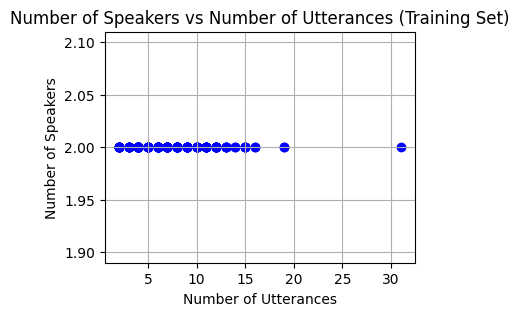

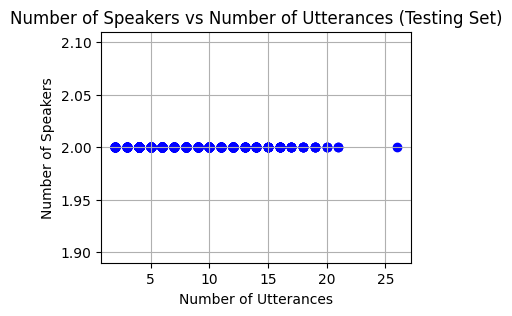

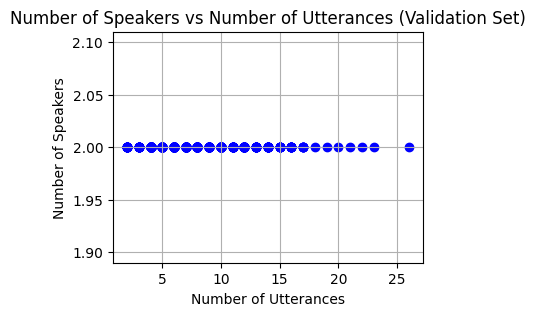

In [8]:
plot_speakers_vs_utterances(DailyDialog_training_graphs, 'Training Set')
plot_speakers_vs_utterances(DailyDialog_testing_graphs, 'Testing Set')
plot_speakers_vs_utterances(DailyDialog_validation_graphs, 'Validation Set')

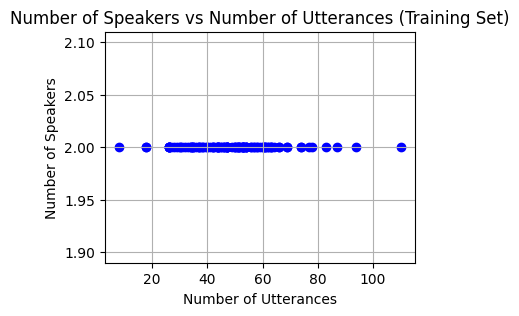

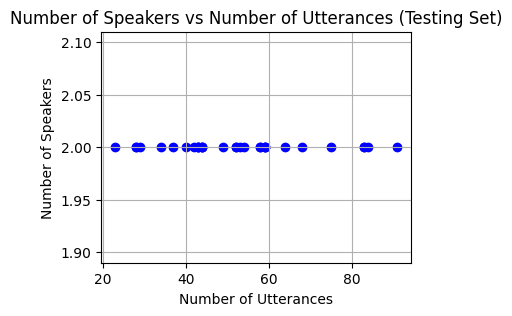

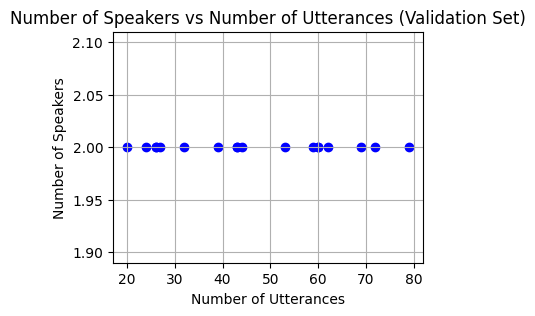

In [9]:
plot_speakers_vs_utterances(IEMOCAP_training_graphs, 'Training Set')
plot_speakers_vs_utterances(IEMOCAP_testing_graphs, 'Testing Set')
plot_speakers_vs_utterances(IEMOCAP_validation_graphs, 'Validation Set')

Below we define the test and train laoder used for model training

In [10]:
from torch_geometric.loader import DataLoader

# Create data loaders as before
MELD_train_loader = DataLoader(MELD_training_graphs, batch_size=32, shuffle=True)
MELD_val_loader = DataLoader(MELD_validation_graphs, batch_size=32, shuffle=False)
MELD_test_loader = DataLoader(MELD_testing_graphs, batch_size=32, shuffle=False)

# Create data loaders
IEMOCAP_train_loader = DataLoader(IEMOCAP_training_graphs, batch_size=5, shuffle=True)
IEMOCAP_val_loader = DataLoader(IEMOCAP_validation_graphs, batch_size=5, shuffle=False)
IEMOCAP_test_loader = DataLoader(IEMOCAP_testing_graphs, batch_size=5, shuffle=False)

# Create data loaders
DailyDialog_train_loader = DataLoader(DailyDialog_training_graphs, batch_size=32, shuffle=True)
DailyDialog_val_loader = DataLoader(DailyDialog_validation_graphs, batch_size=32, shuffle=False)
DailyDialog_test_loader = DataLoader(DailyDialog_testing_graphs, batch_size=32, shuffle=False)

In [11]:
import torch
import torch.optim as optim
import numpy as np
import copy

# post processing random forest step
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

device = torch.device("cuda")

# Function for training the model
def train_model(model, train_loader, val_loader, hyperparameters, model_name="best_model.pth", loss_fn = torch.nn.CrossEntropyLoss()):
    
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])
    # Use a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    num_epochs = hyperparameters['num_epochs']
    patience = hyperparameters['patience']
    print_every = hyperparameters['print_every']
    best_model_state = None
    best_model_state_rm = None

    best_composite_score = np.inf
    best_f1_rm = 0
    patience_counter = 0

    print("============================= STARTING TRAINING ==================================")

    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            # get predictions and output
            output = model(batch) 
            output = output.squeeze(1)
            labels = batch.y

            # Compute loss for batch
            batch_loss = loss_fn(output, labels)

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()
            
            train_loss += batch_loss.item()

        avg_train_loss = train_loss / len(train_loader)
        # Evaluate on validation set
        val_probs, val_labels, val_loss = evaluate_model(model, val_loader, loss_fn=loss_fn)
        
        
        # Step the scheduler with the validation loss
        scheduler.step(val_loss)

        # Print updates every n epochs
        if (epoch + 1) % print_every == 0:
            print(f'\n===================== Epoch [{epoch+1}/{num_epochs}] =======================')
            print(f'Train Loss: {avg_train_loss:.4f}  |  Val Loss: {val_loss:.4f}')
        
            
        # Early stopping based on validation loss
        composite_score = (0.75*val_loss) + (0.25*avg_train_loss)
        
        if composite_score < best_composite_score:
            best_composite_score = composite_score
            patience_counter = 0
            # Save model if it improves
            best_model_state = copy.deepcopy(model.state_dict())
            print("Model saved successfully.")
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
            

    best_model = ERC_working_models.ITERMEM(output_dim=7).to(device)
    best_model.load_state_dict(best_model_state)

    # Return both the best model state and the final model state
    return model, best_model

# Function for evaluating the model on validation/test sets
def evaluate_model(model, val_loader, loss_fn):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch)
            probs = torch.softmax(output, dim=2).squeeze(1).cpu().numpy()
            output = output.squeeze(1)
            labels = batch.y  # Assuming batch contains ground truth labels for subgraphs
            
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs)
            
            # Compute validation loss
            loss = loss_fn(output, labels)
            val_loss += loss.item()
    
    # Flatten the lists to single arrays
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    
    avg_val_los = val_loss / len(val_loader)

    return all_probs, all_labels, avg_val_los


In [12]:
def compute_class_weights(dataset, scaling_factor=1.0):
    """
    Compute class weights for imbalanced classes.
    
    :param labels: A tensor or list containing all the true labels from the dataset.
    :return: A tensor with the weights for each class.
    """

    # Define loss function (CrossEntropyLoss for multi-class classification)
    all_labels = []

    # Iterate through the entire dataset to collect all labels
    for data in dataset:
        all_labels.append(data.y)  # Assuming each graph has a 'y' attribute with the labels
    # Concatenate all labels into a single tensor
    all_labels = torch.cat(all_labels, dim=0)
    
    unique_labels, counts = torch.unique(all_labels, return_counts=True)
    
    # Compute the inverse of the frequency of each class
    total_samples = len(all_labels)
    class_weights = total_samples / (len(unique_labels) * counts.float())
    # Apply the scaling factor to soften the weights
    class_weights = torch.pow(class_weights, scaling_factor)
    
    print("Inverse class frequencies: ", class_weights)
    
    return class_weights

In [13]:
hyperparameters = {
    'num_epochs': 100,  
    'learning_rate': 0.0005,  
    'patience': 10, 
    'print_every': 1  
}

In [15]:
class_weights = compute_class_weights(DailyDialog_training_graphs, 0.25)
class_weights = class_weights.to(device)
loss_fn_weighted = torch.nn.CrossEntropyLoss(weight=class_weights)

Inverse class frequencies:  tensor([0.6596, 1.9089, 1.8286, 2.4393, 0.9453, 2.5531, 1.4149])


In [16]:
import importlib
import ERC_working_models
importlib.reload(ERC_working_models)

<module 'ERC_working_models' from '/home/manuel.nunez/VANESSA/GroupCohesionPrediction/GNNs/ERC/ERC_working_models.py'>

In [17]:
# train_model(model, IEMOCAP_test_loader,  IEMOCAP_val_loader, hyperparameters, model_name="ITERMEM_NodeLevel_IEMOCAP_padded_weighted", loss_fn=loss_fn_weighted)
model = ERC_working_models.ITERMEM(output_dim=7).to(device)
last_model, best_model = train_model(model, DailyDialog_test_loader,  DailyDialog_val_loader, hyperparameters, loss_fn = loss_fn_weighted)

/blue/bonniejdorr/manuel.nunez/.conda/envs/VANESSA_env/lib/python3.13/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/blue/bonniejdorr/manuel.nunez/.conda/envs/VANESSA_env/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


============================= STARTING TRAINING ==================================

===================== Epoch [1/100] =======================
Train Loss: 1.1170  |  Val Loss: 0.9332
Model saved successfully.

===================== Epoch [2/100] =======================
Train Loss: 1.0664  |  Val Loss: 0.8811
Model saved successfully.

===================== Epoch [3/100] =======================
Train Loss: 1.0733  |  Val Loss: 0.8053
Model saved successfully.

===================== Epoch [4/100] =======================
Train Loss: 1.0505  |  Val Loss: 0.8211

===================== Epoch [5/100] =======================
Train Loss: 1.0430  |  Val Loss: 0.8965

===================== Epoch [6/100] =======================
Train Loss: 1.0394  |  Val Loss: 0.8389

===================== Epoch [7/100] =======================
Train Loss: 1.0122  |  Val Loss: 0.8016
Model saved successfully.

===================== Epoch [8/100] =======================
Train Loss: 0.9222  |  Val Loss: 0.7028
Model

In [18]:
import performance_functions
from performance_functions import *

# train_probs, train_preds, train_labels = get_model_probs_preds_labels(best_model, MELD_train_loader, device) 
# val_probs, val_preds, val_labels = get_model_probs_preds_labels(best_model, MELD_val_loader, device) 
test_probs, test_preds, test_labels = get_model_probs_preds_labels(best_model, DailyDialog_test_loader, device) 

The function below evaluates a model, plots a confusion matrix, and print the weighted F1 score 

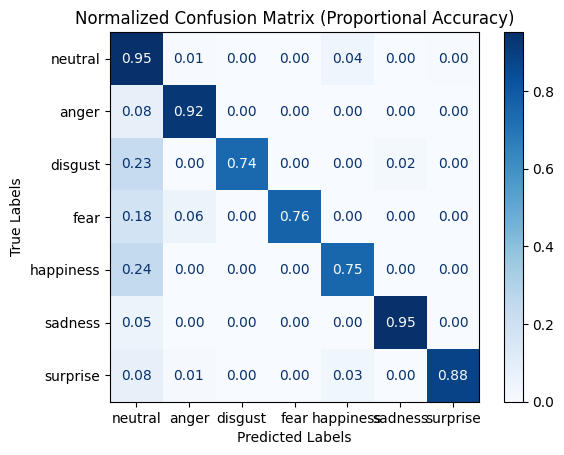


Per-Class Accuracy and F1 Scores:
neutral: Accuracy: 0.95, F1 Score: 0.95
anger: Accuracy: 0.92, F1 Score: 0.82
disgust: Accuracy: 0.74, F1 Score: 0.81
fear: Accuracy: 0.76, F1 Score: 0.87
happiness: Accuracy: 0.75, F1 Score: 0.75
sadness: Accuracy: 0.95, F1 Score: 0.90
surprise: Accuracy: 0.88, F1 Score: 0.82

Weighted Accuracy (Overall): 0.9194
Weighted F1 Score (Overall): 0.9197


In [19]:
importlib.reload(performance_functions)
MELD_class_names = ['anger', 'disgust', 'sadness', 'joy', 'neutral', 'surprise', 'fear']
IEMOCAP_class_names = ['hap', 'sad', 'neu', 'ang', 'exc', 'fru']
DailyDialog_class_names = ['neutral', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']


confusion_matrix_plus_stats(test_labels, test_preds, DailyDialog_class_names)


In [49]:
rm_probs = np.concatenate((train_probs, val_probs), axis=0)
rm_labels = np.concatenate((train_labels, val_labels), axis=0)
rm_model = ERC_working_models.train_random_forest_on_probabilities(rm_probs, rm_labels)
# Make predictions on the test set
test_preds = rm_model.predict(test_probs) 
# Use your provided confusion matrix and stats function
confusion_matrix_plus_stats(test_labels, test_preds, MELD_class_names)

NameError: name 'train_probs' is not defined

In [54]:
best_MELD_Model = best_model #Only OG augmented Data, weighted classes, dynamic learning rate 

In [45]:
best_IEMOCAP_Model = best_model #weighted classes (0.5 scale), dynamic learning rate 

In [63]:

torch.save(best_MELD_Model, 'ERC_Models/best_MELD_Model.pth')

AttributeError: '_pickle.Pickler' object attribute 'persistent_id' is read-only

In [62]:
!pwd

/home/manuel.nunez/VANESSA/GroupCohesionPrediction/GNNs/ERC
